In [1]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report
from lib.train_utils import random_subsample
data = []
device = 'cuda'

experiments_dir = f'./experiments'

criterion = nn.BCEWithLogitsLoss()

for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/metrics.json'):
            continue
        
        metrics = json.load(open(f'{experiments_dir}/{experiment}/{run}/metrics.json'))
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        # if hyperparameters['mode'] == 'target_only_fine_tuning':
        #     # Best base model path
        #     best_base_model_path = f"{experiments_dir}/{experiment}/{run}/best_base_model.pt"
        #     target_participant = hyperparameters['target_participant']
        #     data_path = hyperparameters['data_path']
        #     batch_size = hyperparameters['batch_size']
        #     target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
        #     target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))
            
        #     target_val_dataset = random_subsample(target_val_dataset, .1)

        #     target_valloader = DataLoader(target_val_dataset, batch_size=batch_size, shuffle=False)
        #     target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False)

        #     model = TestModel()
        #     model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
        #     model.to(device)

        #     val_loss, val_f1 = compute_loss_and_f1(model, target_valloader, criterion, device=device)
        #     test_loss, test_f1 = compute_loss_and_f1(model, target_testloader, criterion, device=device)
        #     metrics['best_base_model_target_val_f1'] = val_f1
        #     metrics['best_base_model_target_test_f1'] = test_f1
        #     metrics['best_base_model_target_val_loss'] = val_loss
        #     metrics['best_base_model_target_test_loss'] = test_loss

        data.append({
            'hyperparameter_hash': experiment.split('_')[-1],
            'batch_size': hyperparameters['batch_size'], 
            'fold': int(run.split('_')[0].replace('fold','')), 
            'target_data_pct': float(hyperparameters['target_data_pct']), 
            'n_base_participants': int(hyperparameters['n_base_participants']),
            'mode': hyperparameters['mode'],
            'best_target_model_target_val_f1': metrics['best_target_model_target_val_f1'], 
            'best_target_model_target_test_f1': metrics['best_target_model_target_test_f1'],
            'best_base_model_target_val_f1': metrics['best_base_model_target_val_f1'] if 'best_base_model_target_val_f1' in metrics else None,
            'best_base_model_target_test_f1': metrics['best_base_model_target_test_f1'] if 'best_base_model_target_test_f1' in metrics else None,
            'best_target_model_target_val_loss': metrics['best_target_model_target_val_loss'] if 'best_target_model_target_val_loss' in metrics else None,
            'best_target_model_target_test_loss': metrics['best_target_model_target_test_loss'] if 'best_target_model_target_test_loss' in metrics else None,
            'best_base_model_target_val_loss': metrics['best_base_model_target_val_loss'] if 'best_base_model_target_val_loss' in metrics else None,
            'best_base_model_target_test_loss': metrics['best_base_model_target_test_loss'] if 'best_base_model_target_test_loss' in metrics else None,
            'absolute_improvement_target_test_f1': (metrics['best_target_model_target_test_f1'] - metrics['best_base_model_target_test_f1']) if 'best_base_model_target_test_f1' in metrics else None,
            'absolute_improvement_target_val_f1': (metrics['best_target_model_target_val_f1'] - metrics['best_base_model_target_val_f1']) if 'best_base_model_target_val_f1' in metrics else None,
            'relative_improvement_target_test_f1': ((metrics['best_target_model_target_test_f1'] - metrics['best_base_model_target_test_f1']) / metrics['best_base_model_target_test_f1']) if 'best_base_model_target_test_f1' in metrics and metrics['best_base_model_target_test_f1'] != 0 else None,
            'relative_improvement_target_val_f1': ((metrics['best_target_model_target_val_f1'] - metrics['best_base_model_target_val_f1']) / metrics['best_base_model_target_val_f1']) if 'best_base_model_target_val_f1' in metrics and metrics['best_base_model_target_val_f1'] != 0 else None,
        })
        
df = pd.DataFrame(data)

100%|██████████| 218/218 [00:00<00:00, 402.57it/s]


<Axes: xlabel='mode', ylabel='best_target_model_target_val_f1'>

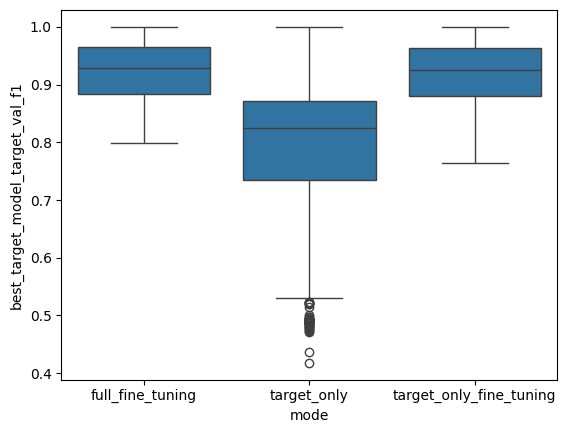

In [2]:
# Pick best target_data_pct via validation f1
# sns.boxplot(data=df, x='target_data_pct', y='best_target_model_target_val_f1', hue='mode')
# sns.boxplot(data=df, x='mode', y='best_target_model_target_val_f1', hue='target_data_pct')
sns.boxplot(data=df, x='mode', y='best_target_model_target_val_f1')
# sns.boxplot(data=df, x='target_data_pct', y='absolute_improvement_target_val_f1', hue='mode')

<Axes: xlabel='batch_size', ylabel='best_target_model_target_val_f1'>

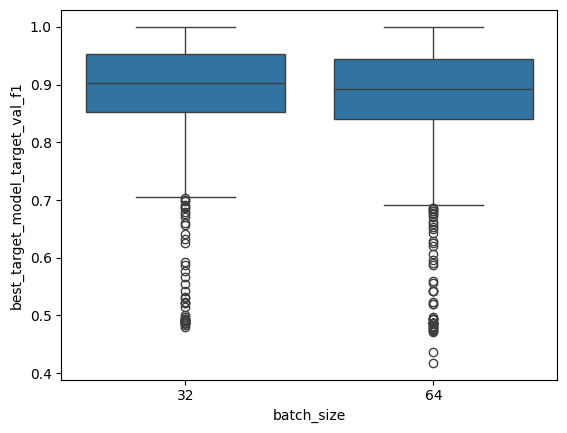

In [4]:
# Pick best batch_size via validation f1
sns.boxplot(data=df, x='batch_size', y='best_target_model_target_val_f1')
# sns.boxplot(data=df, x='batch_size', y='absolute_improvement_target_val_f1')

ValueError: List of boxplot statistics and `positions` values must have same the length

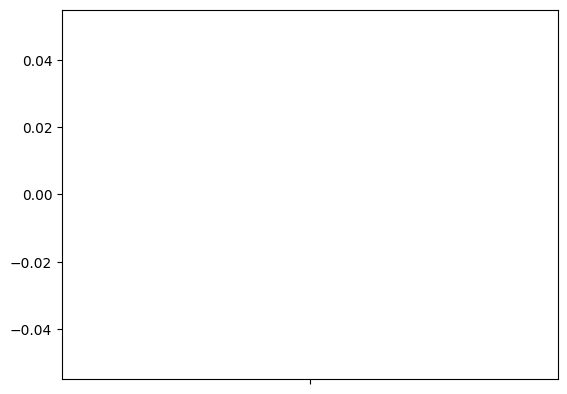

In [ ]:
# Plot absolute improvement
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
df_plot = df_plot[df_plot['batch_size'] == 32]
sns.boxplot(data=df_plot, y='absolute_improvement_target_test_f1')
plt.axhline(0, color='red', linestyle='--')
# df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
# sns.boxplot(data=df_plot, x='metric', y='value',ax=ax[0,0])

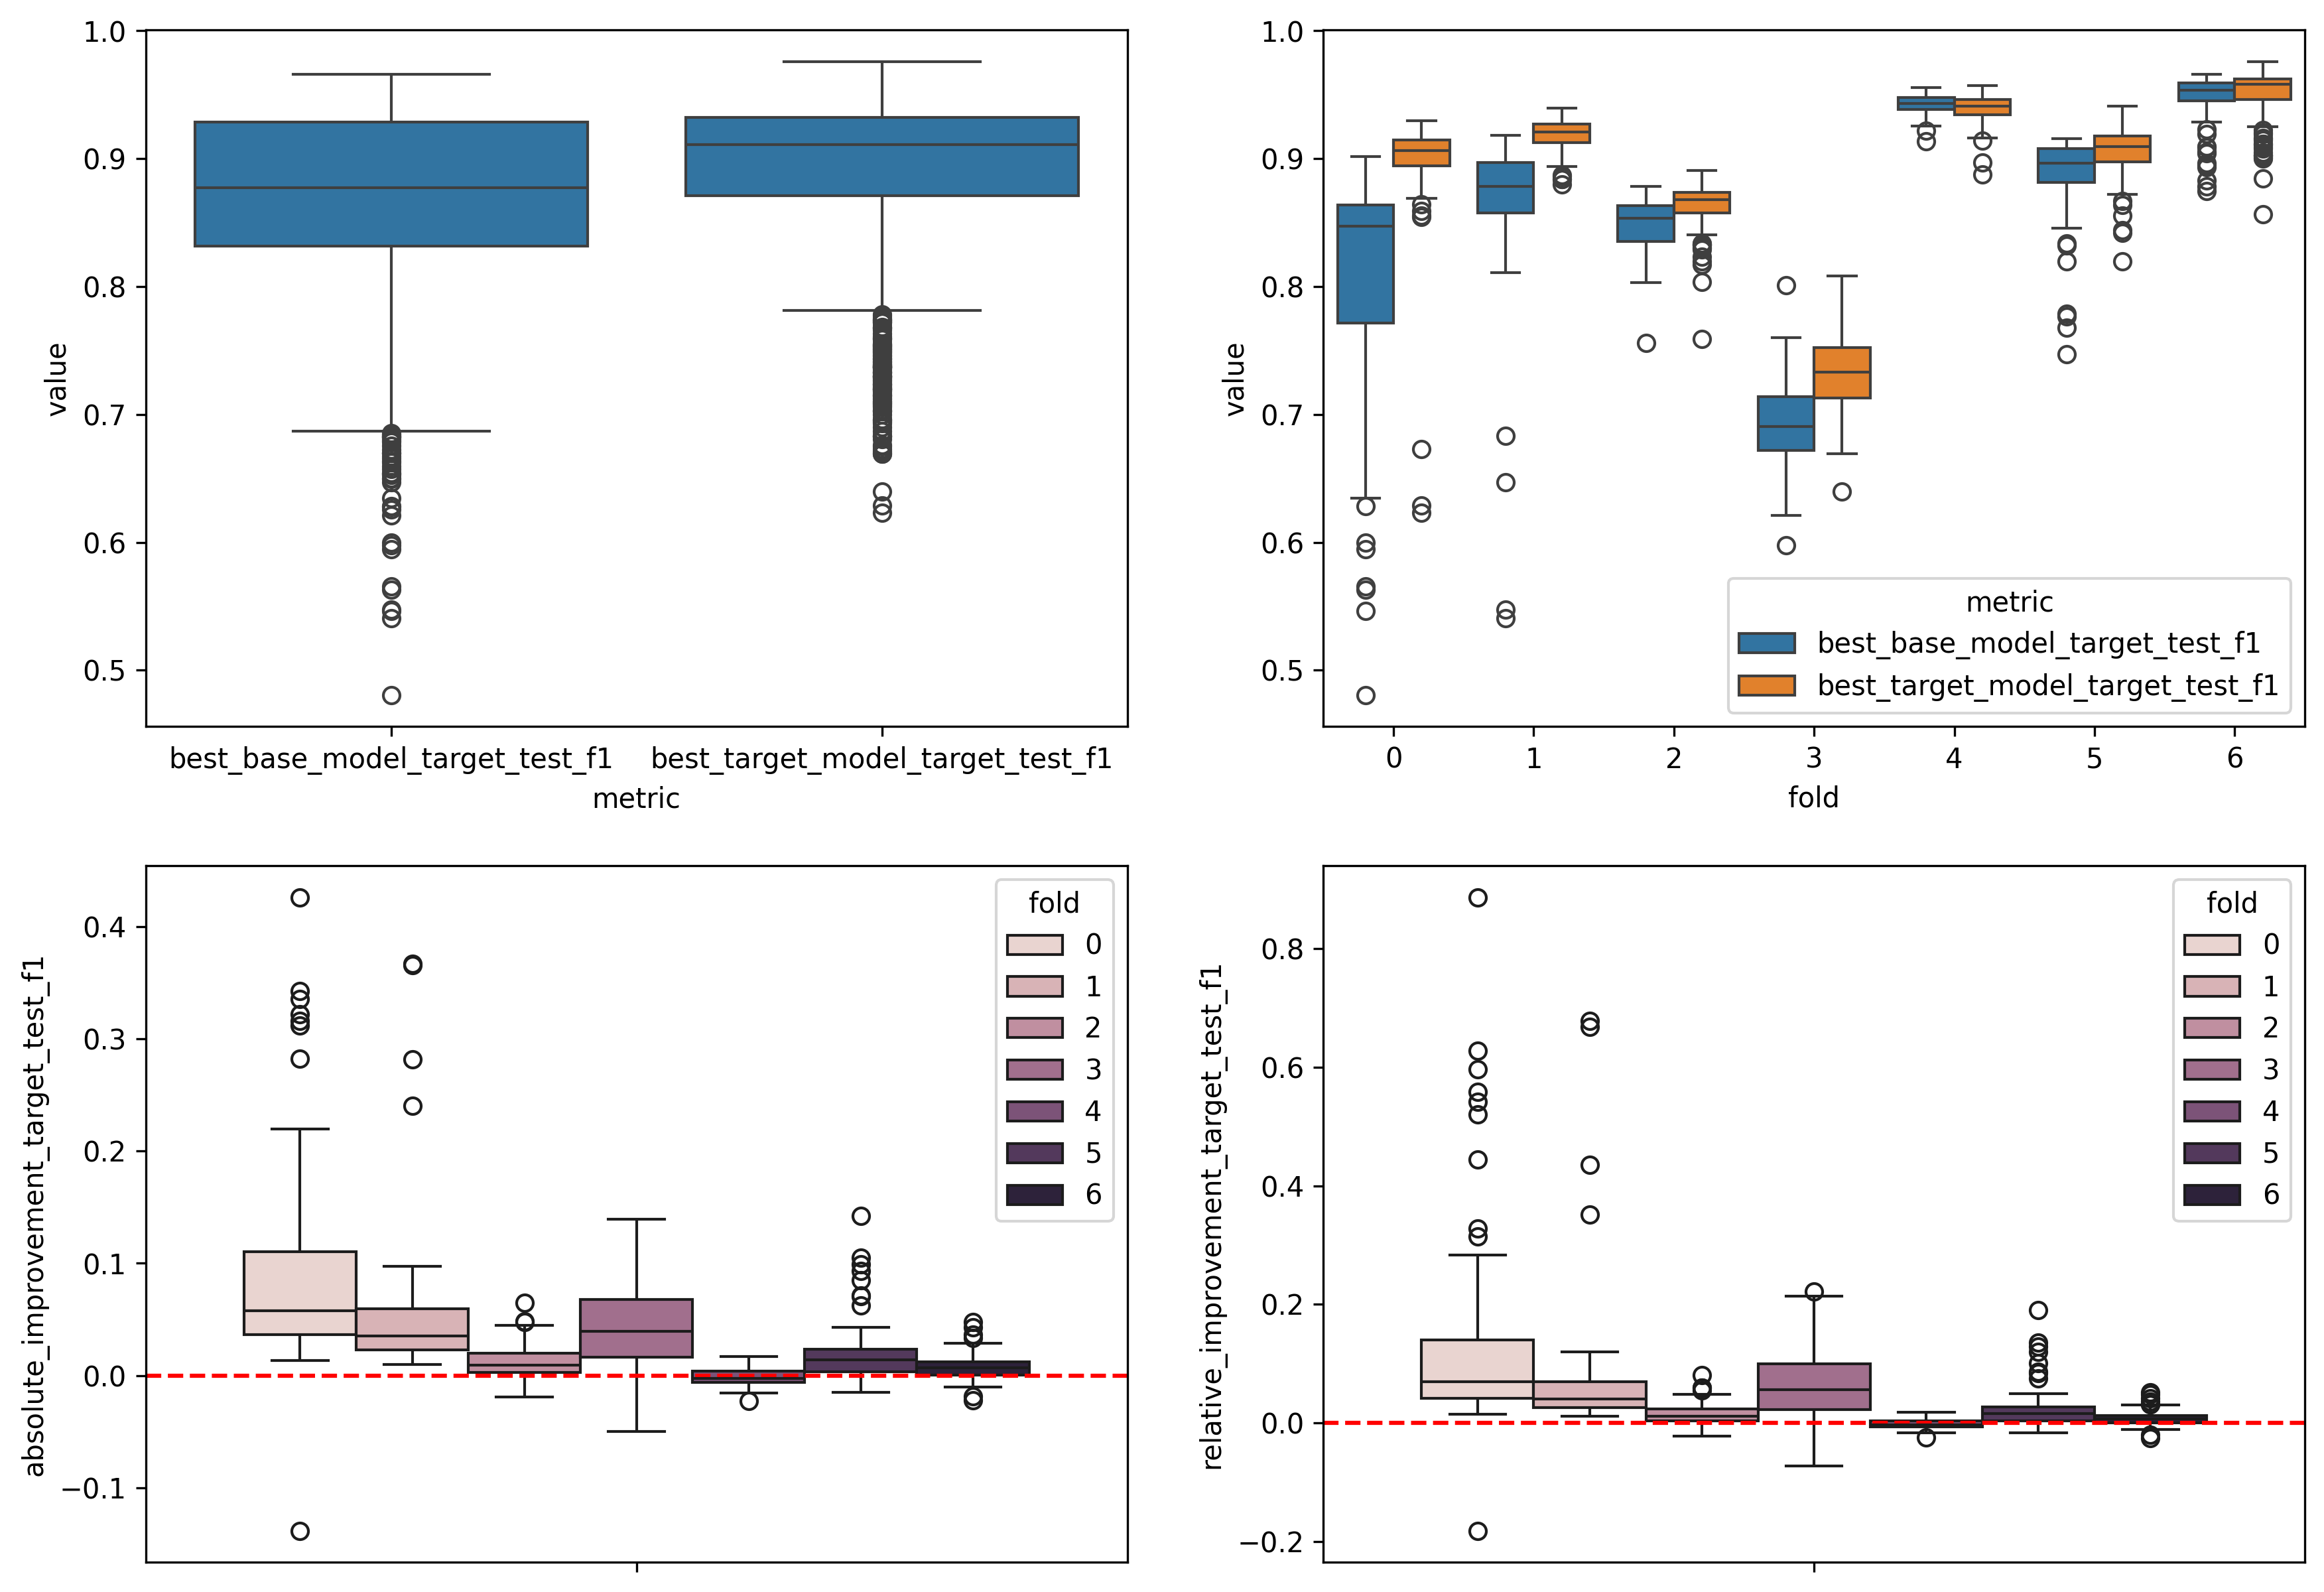

In [6]:
fig,ax = plt.subplots(2,2, figsize=(14,10),dpi=300)

df_plot = df.copy()
df_plot = df_plot[(df_plot['mode'] == 'full_fine_tuning') | (df_plot['mode'] == 'target_only_fine_tuning')]
# df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
# df_plot = df_plot[df_plot['batch_size'] == 32]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
sns.boxplot(data=df_plot, x='metric', y='value', ax=ax[0,0])

df_plot = df.copy()
df_plot = df_plot[(df_plot['mode'] == 'full_fine_tuning') | (df_plot['mode'] == 'target_only_fine_tuning')]
# df_plot = df_plot[df_plot['target_data_pct'] == 1.0] # TODO: is this cheating, how do I pick this?
# df_plot = df_plot[df_plot['batch_size'] == 32]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
sns.boxplot(data=df_plot, x='fold', y='value',hue='metric',ax=ax[0,1])

df_plot = df.copy()
df_plot = df_plot[(df_plot['mode'] == 'full_fine_tuning') | (df_plot['mode'] == 'target_only_fine_tuning')]
sns.boxplot(data=df_plot, y='absolute_improvement_target_test_f1', hue='fold', ax=ax[1,0])
ax[1,0].axhline(0, color='red', linestyle='--')

df_plot = df.copy()
df_plot = df_plot[(df_plot['mode'] == 'full_fine_tuning') | (df_plot['mode'] == 'target_only_fine_tuning')]
sns.boxplot(data=df_plot, y='relative_improvement_target_test_f1', hue='fold', ax=ax[1,1])
ax[1,1].axhline(0, color='red', linestyle='--')

plt.savefig('figure1.pdf', bbox_inches='tight')

In [211]:
# melt by target data pct and describe best_target_model_target_test_f1
df.melt(value_vars=['best_target_model_target_test_f1'],id_vars=['n_base_participants','mode'], var_name='metric', value_name='value').groupby(['n_base_participants','mode']).describe()

value                      \
                                            count      mean       std   
n_base_participants mode                                                
1                   full_fine_tuning         84.0  0.873273  0.067230   
                    target_only              97.0  0.745477  0.163055   
                    target_only_fine_tuning  56.0  0.868903  0.071820   
2                   full_fine_tuning         84.0  0.882661  0.081838   
                    target_only              84.0  0.771141  0.139615   
                    target_only_fine_tuning  52.0  0.884845  0.076877   
3                   full_fine_tuning         84.0  0.888995  0.073506   
                    target_only              84.0  0.760551  0.145664   
                    target_only_fine_tuning  50.0  0.887922  0.069518   
4                   full_fine_tuning         83.0  0.891673  0.066220   
                    target_only              84.0  0.762406  0.146655   
                    target_only_fine_tuning  49.0  0.889324  0.069563   
5                   full_fine_tuning         84.0  0.892913  0.070398   
                    target_only              84.0  0.777240  0.137367   
                    target_only_fine_tuning  49.0  0.892119  0.070591   
6                   full_fine_tuning         83.0  0.891424  0.075456   
                    target_only              84.0  0.781720  0.133533   
                    target_only_fine_tuning  49.0  0.894922  0.067969   

                                                                           \
                                                  min       25%       50%   
n_base_participants mode                                                    
1                   full_fine_tuning         0.672770  0.839935  0.898407   
                    target_only              0.361563  0.608809  0.834260   
                    target_only_fine_tuning  0.629002  0.842125  0.888145   
2                   full_fine_tuning         0.623159  0.868188  0.909569   
                    target_only              0.489586  0.640850  0.839675   
                    target_only_fine_tuning  0.669216  0.860656  0.908898   
3                   full_fine_tuning         0.676242  0.869486  0.909644   
                    target_only              0.489586  0.638796  0.834089   
                    target_only_fine_tuning  0.693395  0.872262  0.911721   
4                   full_fine_tuning         0.703345  0.870735  0.909965   
                    target_only              0.489586  0.611065  0.837834   
                    target_only_fine_tuning  0.720577  0.871901  0.914183   
5                   full_fine_tuning         0.682648  0.876691  0.916375   
                    target_only              0.471593  0.670213  0.838910   
                    target_only_fine_tuning  0.695587  0.876725  0.913558   
6                   full_fine_tuning         0.639842  0.872520  0.917300   
                    target_only              0.489586  0.682011  0.846894   
                    target_only_fine_tuning  0.686940  0.880634  0.918543   

                                                                 
                                                  75%       max  
n_base_participants mode                                         
1                   full_fine_tuning         0.916456  0.947742  
                    target_only              0.875068  1.000000  
                    target_only_fine_tuning  0.917232  0.950948  
2                   full_fine_tuning         0.939045  0.963275  
                    target_only              0.872120  0.934245  
                    target_only_fine_tuning  0.930742  0.962855  
3                   full_fine_tuning         0.939820  0.975790  
                    target_only              0.872964  0.926712  
                    target_only_fine_tuning  0.929344  0.962425  
4                   full_fine_tuning         0.934658  0.972300  
                    target_only   

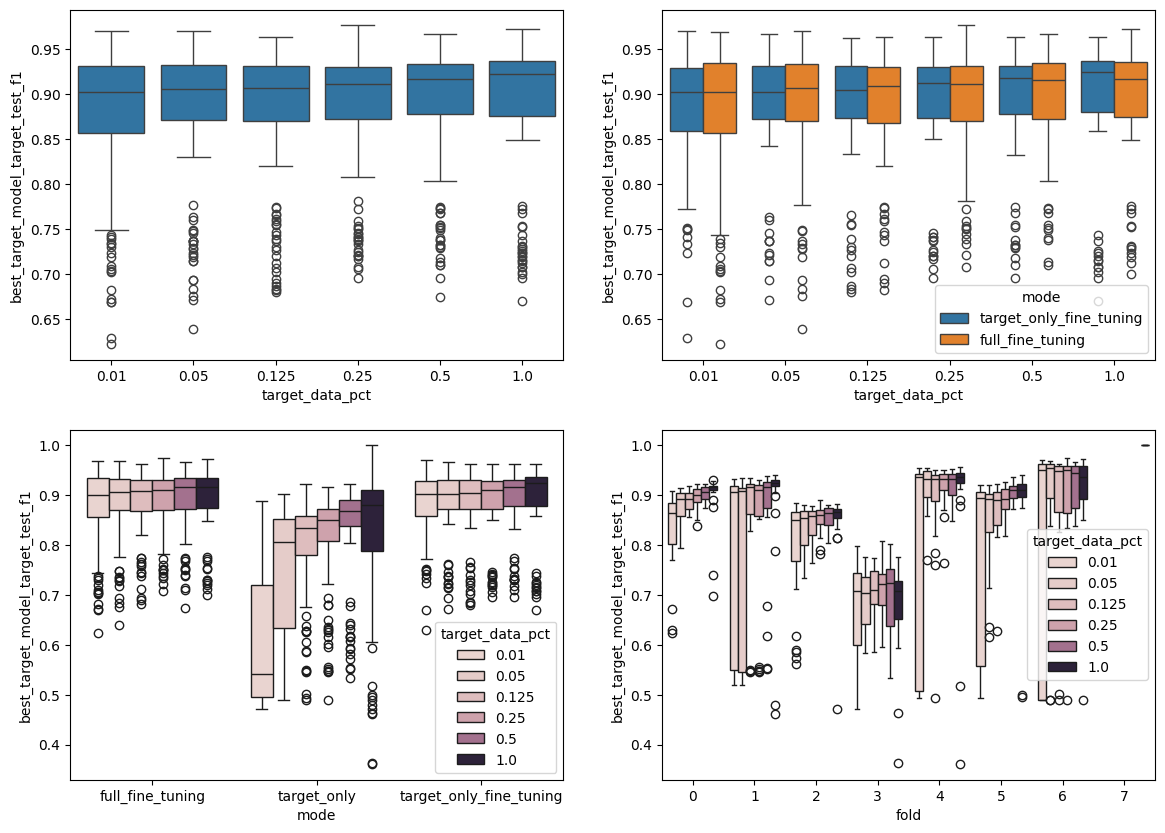

In [7]:
fig,ax = plt.subplots(2,2, figsize=(14,10))
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']  # n_base_participants doesn't have anything to do with target_only mode
sns.boxplot(data=df_plot, x='target_data_pct', y='best_target_model_target_test_f1', ax=ax[0,0])
sns.boxplot(data=df_plot, x='target_data_pct', y='best_target_model_target_test_f1', hue='mode', ax=ax[0,1])

df_plot = df.copy()
sns.boxplot(data=df_plot, x='mode', y='best_target_model_target_test_f1', hue='target_data_pct', ax=ax[1,0])
sns.boxplot(data=df_plot, x='fold', y='best_target_model_target_test_f1', hue='target_data_pct', ax=ax[1,1])

plt.savefig('figure2.pdf', bbox_inches='tight')

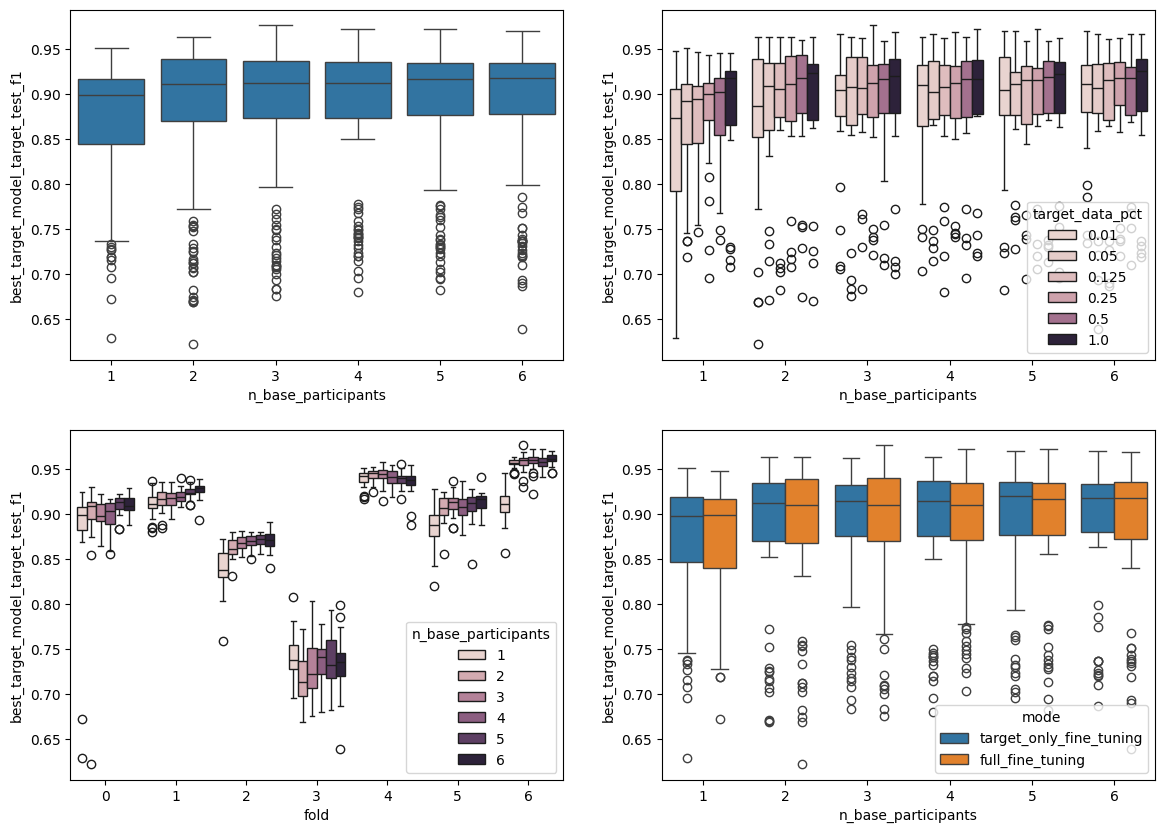

In [8]:
df_plot = df.copy()
# n_base_participants doesn't have anything to do with target_only mode
df_plot = df_plot[df_plot['mode'] != 'target_only']
fig,ax = plt.subplots(2,2, figsize=(14,10))
sns.boxplot(data=df_plot, x='n_base_participants', y='best_target_model_target_test_f1', ax=ax[0,0])
sns.boxplot(data=df_plot, x='n_base_participants', y='best_target_model_target_test_f1', hue='target_data_pct', ax=ax[0,1])
sns.boxplot(data=df_plot, x='fold', y='best_target_model_target_test_f1', hue='n_base_participants', ax=ax[1,0])
sns.boxplot(data=df_plot, x='n_base_participants', y='best_target_model_target_test_f1', hue='mode', ax=ax[1,1])
plt.savefig('figure3.pdf', bbox_inches='tight')

61c4dfba


,hyperparameter_hash,batch_size,fold,target_data_pct,n_base_participants,mode,best_target_model_target_val_f1,best_target_model_target_test_f1,best_base_model_target_val_f1,best_base_model_target_test_f1,best_target_model_target_val_loss,best_target_model_target_test_loss,best_base_model_target_val_loss,best_base_model_target_test_loss,absolute_improvement_target_test_f1,absolute_improvement_target_val_f1,relative_improvement_target_test_f1,relative_improvement_target_val_f1
460,61c4dfba,64,4,1.0,4,full_fine_tuning,1.000000,0.943886,0.953176,0.954331,0.002499,0.016863,0.007558,0.015653,-0.010445,0.046824,-0.010945,0.049125
461,61c4dfba,64,1,1.0,4,full_fine_tuning,0.954304,0.925090,0.885282,0.872096,0.034892,0.047301,0.070219,0.070918,0.052994,0.069022,0.060767,0.077966
462,61c4dfba,64,3,1.0,4,full_fine_tuning,0.879907,0.768447,0.847280,0.757142,0.129341,0.097208,0.161633,0.108018,0.011305,0.032627,0.014931,0.038508
463,61c4dfba,64,6,1.0,4,full_fine_tuning,1.000000,0.965755,0.925346,0.962855,0.005640,0.019101,0.025717,0.022802,0.002900,0.074654,0.003012,0.080677
464,61c4dfba,64,5,1.0,4,full_fine_tuning,0.913954,0.896523,0.791364,0.911271,0.033884,0.039376,0.046610,0.029560,-0.014749,0.122591,-0.016185,0.154911
465,61c4dfba,64,0,1.0,4,full_fine_tuning,0.954669,0.912278,0.864929,0.852632,0.048899,0.062498,0.083237,0.093617,0.059646,0.089740,0.069955,0.103754
466,61c4dfba,64,2,1.0,4,full_fine_tuning,0.951994,0.874950,0.938676,0.854556,0.038804,0.072560,0.044573,0.075249,0.020395,0.013319,0.023866,0.014189


Loading model from b64_t1.0_20251001_201839_61c4dfba
Runs: ['fold4_ejaz', 'fold1_asfik', 'fold3_anam', 'fold6_unk1', 'fold5_iftakhar', 'fold0_tonmoy', 'fold2_alsaad']
Loading model from fold4_ejaz
Loading data from data/001_60s_window for target participant ejaz
Target val dataset size: 1887
Target val dataset size: 1887
Loading base model from ./experiments/b64_t1.0_20251001_201839_61c4dfba/fold4_ejaz/best_base_model.pt
              precision    recall  f1-score   support

  No Smoking       1.00      1.00      1.00      6047
     Smoking       0.98      0.85      0.91       162

    accuracy                           1.00      6209
   macro avg       0.99      0.93      0.95      6209
weighted avg       1.00      1.00      1.00      6209

Loading model from fold1_asfik
Loading data from data/001_60s_window for target participant asfik
Target val dataset size: 4747
Target val dataset size: 4747
Loading base model from ./experiments/b64_t1.0_20251001_201839_61c4dfba/fold1_asfik/best_b

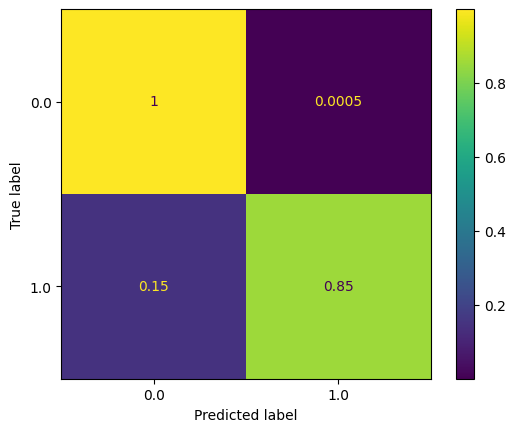

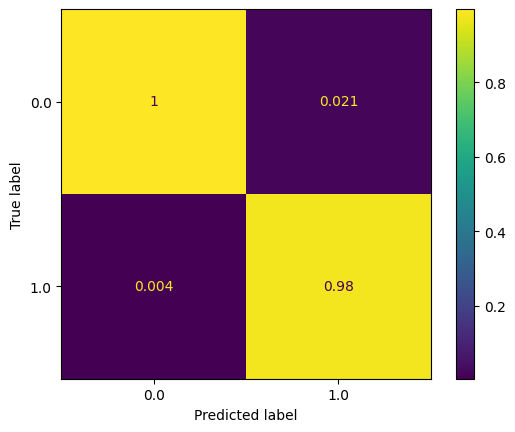

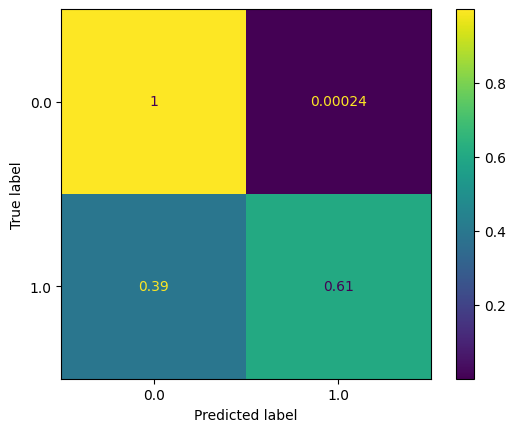

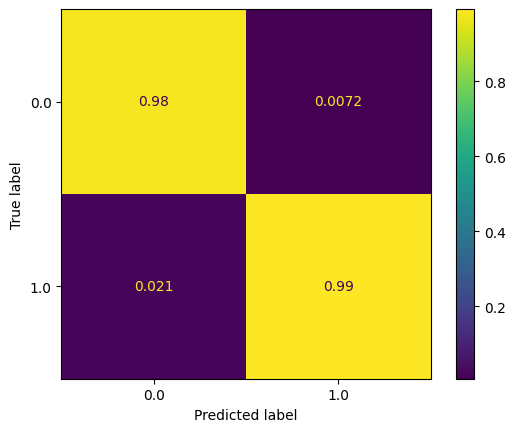

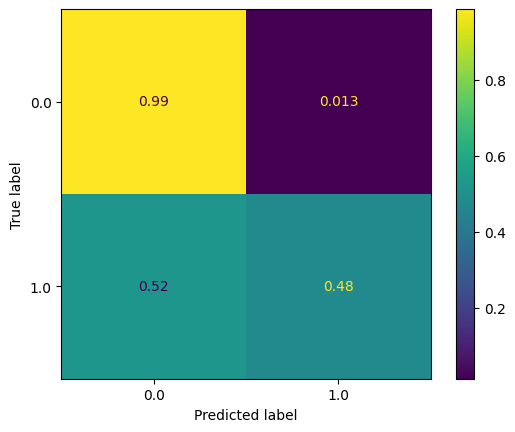

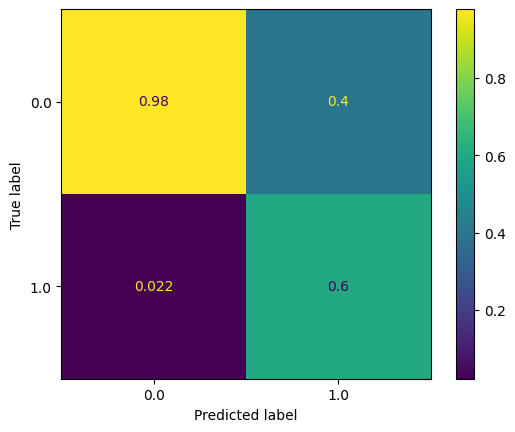

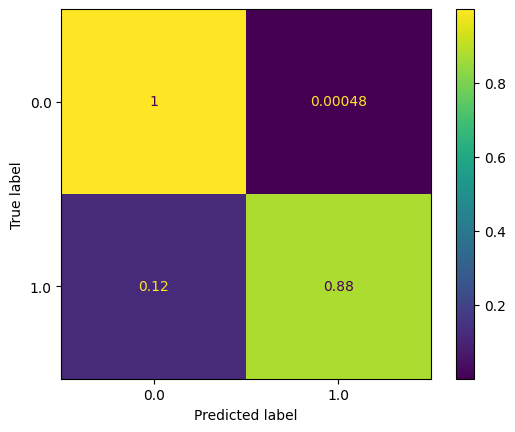

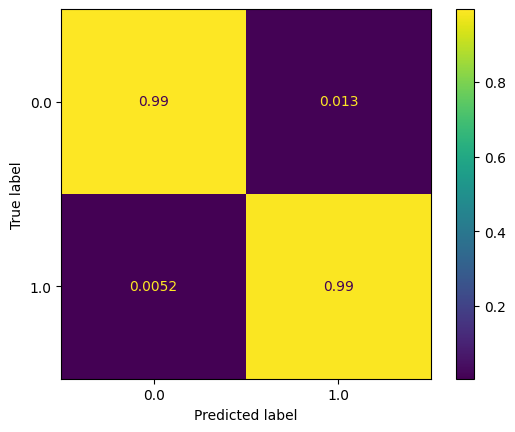

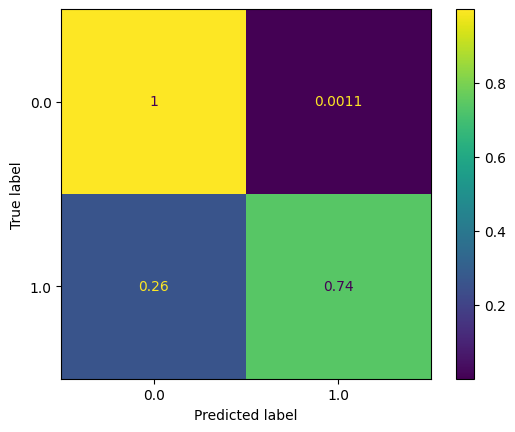

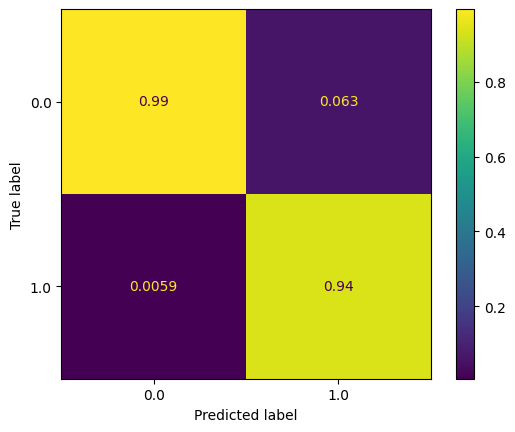

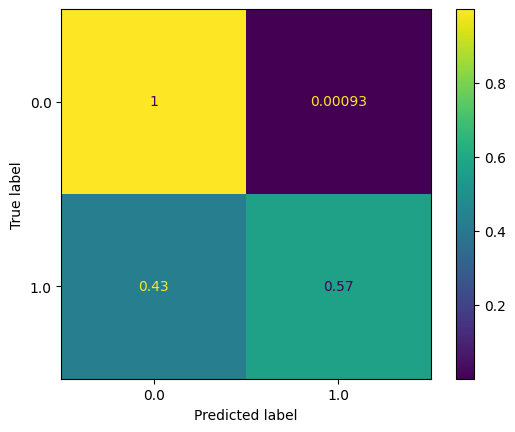

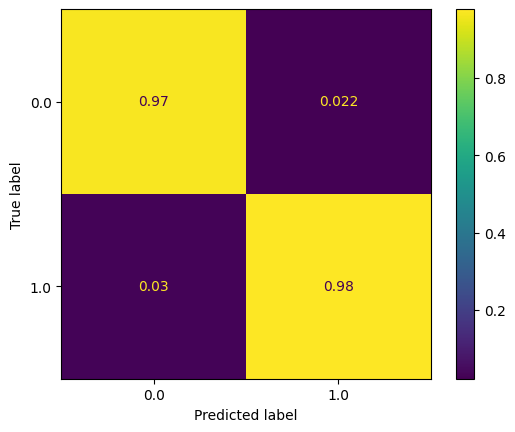

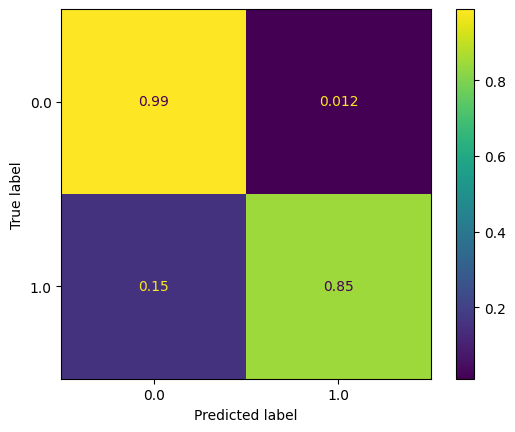

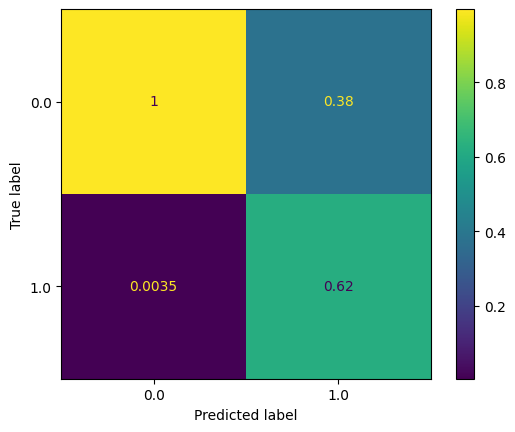

In [9]:
# get best model hash where all folds had positive val f1 improvement
best_model_hash = df.groupby('hyperparameter_hash')['relative_improvement_target_val_f1'].filter(lambda x: (x > 0).all()).index
best_model_hash = df.loc[best_model_hash]['hyperparameter_hash'].unique()[0]
print(best_model_hash)
df_metrics = df[df['hyperparameter_hash'] == best_model_hash].copy()
# Compute Metrics For Paper
display(df_metrics)
df_metrics = df_metrics[['fold','best_base_model_target_test_f1','best_target_model_target_test_f1']]
df_metrics.sort_values('fold', inplace=True)
# Add Absolute Improvement
df_metrics['absolute_improvement'] = df_metrics['best_target_model_target_test_f1'] - df_metrics['best_base_model_target_test_f1']
# Add Relative Improvement
df_metrics['relative_improvement'] = df_metrics['absolute_improvement'] / df_metrics['best_base_model_target_test_f1']
# Add Room For Improvement Metric
df_metrics['room_for_improvement'] = (1 - df_metrics['best_base_model_target_test_f1'])
df_metrics['room_for_improvement_pct'] = df_metrics['absolute_improvement'] / df_metrics['room_for_improvement']

from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report
from lib.train_utils import random_subsample
device = 'cpu'

# Load Model From Best Model Hash
# You can change this to load a different model if you want to inspect it
best_model_dir = [d for d in os.listdir(experiments_dir) if best_model_hash in d][0]
print(f'Loading model from {best_model_dir}')

run_dirs = os.listdir(f'{experiments_dir}/{best_model_dir}')
print(f'Runs: {run_dirs}')

df_metrics['best_target_model_target_test_precision'] = 0.0
df_metrics['best_target_model_target_test_recall'] = 0.0

for run_dir in run_dirs:
    print(f'Loading model from {run_dir}')
    best_base_model_path = f'{experiments_dir}/{best_model_dir}/{run_dir}/best_base_model.pt'

    criterion = nn.BCEWithLogitsLoss()
    hyperparameters = json.load(open(f'{experiments_dir}/{best_model_dir}/{run_dir}/hyperparameters.json'))
    target_participant = hyperparameters['target_participant']
    data_path = hyperparameters['data_path']
    batch_size = hyperparameters['batch_size']
    fold = hyperparameters['fold']
    print(f'Loading data from {data_path} for target participant {target_participant}')
    target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
    target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
    target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

    # Subsample target training data if specified
    target_data_pct = hyperparameters['target_data_pct']
    if target_data_pct < 1.0:
        print(f'Target train dataset size: {len(target_train_dataset)}')
        target_train_dataset = random_subsample(target_train_dataset, target_data_pct)
        print(f'Target train dataset size: {len(target_train_dataset)}')

    print(f'Target val dataset size: {len(target_val_dataset)}')
    target_val_dataset = random_subsample(target_val_dataset, 1)
    print(f'Target val dataset size: {len(target_val_dataset)}')

    target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True)
    target_valloader = DataLoader(target_val_dataset, batch_size=batch_size, shuffle=False)
    target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False)

    model = TestModel()
    print(f'Loading base model from {best_base_model_path}')
    model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
    model.to(device)

    test_loss, test_f1 = compute_loss_and_f1(model, target_testloader, criterion, device=device)
    y_true,y_pred = evaluate(model, target_testloader, device=device)

    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']

    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_precision'] = precision
    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_recall'] = recall

,fold,best_base_model_target_test_f1,best_target_model_target_test_f1,absolute_improvement,relative_improvement,room_for_improvement,room_for_improvement_pct,best_target_model_target_test_precision,best_target_model_target_test_recall
465,0.000000,0.852632,0.912278,0.059646,0.069955,0.147368,0.404742,0.973924,0.785069
461,1.000000,0.872096,0.925090,0.052994,0.060767,0.127904,0.414328,0.985975,0.804324
466,2.000000,0.854556,0.874950,0.020395,0.023866,0.145444,0.140223,0.809003,0.917324
462,3.000000,0.757142,0.768447,0.011305,0.014931,0.242858,0.046548,0.790949,0.731034
460,4.000000,0.954331,0.943886,-0.010445,-0.010945,0.045669,-0.228717,0.987384,0.925678
464,5.000000,0.911271,0.896523,-0.014749,-0.016185,0.088729,-0.166220,0.965342,0.868873
463,6.000000,0.962855,0.965755,0.002900,0.003012,0.037145,0.078064,0.991054,0.937963
median,3.000000,0.872096,0.912278,0.011305,0.014931,0.127904,0.078064,0.973924,0.868873
mean,3.000000,0.879622,0.899901,0.016669,0.020041,0.120378,0.095879,0.934695,0.854892
std,1.870829,0.061219,0.056043,0.025372,0.029110,0.061219,0.216766,0.078311,0.069797


,fold,metric,value
0,0.0,best_base_model_target_test_f1,0.852632
1,1.0,best_base_model_target_test_f1,0.872096
2,2.0,best_base_model_target_test_f1,0.854556
3,3.0,best_base_model_target_test_f1,0.757142
4,4.0,best_base_model_target_test_f1,0.954331
5,5.0,best_base_model_target_test_f1,0.911271
6,6.0,best_base_model_target_test_f1,0.962855
7,0.0,best_target_model_target_test_f1,0.912278
8,1.0,best_target_model_target_test_f1,0.925090
9,2.0,best_target_model_target_test_f1,0.874950


<Axes: xlabel='fold', ylabel='value'>

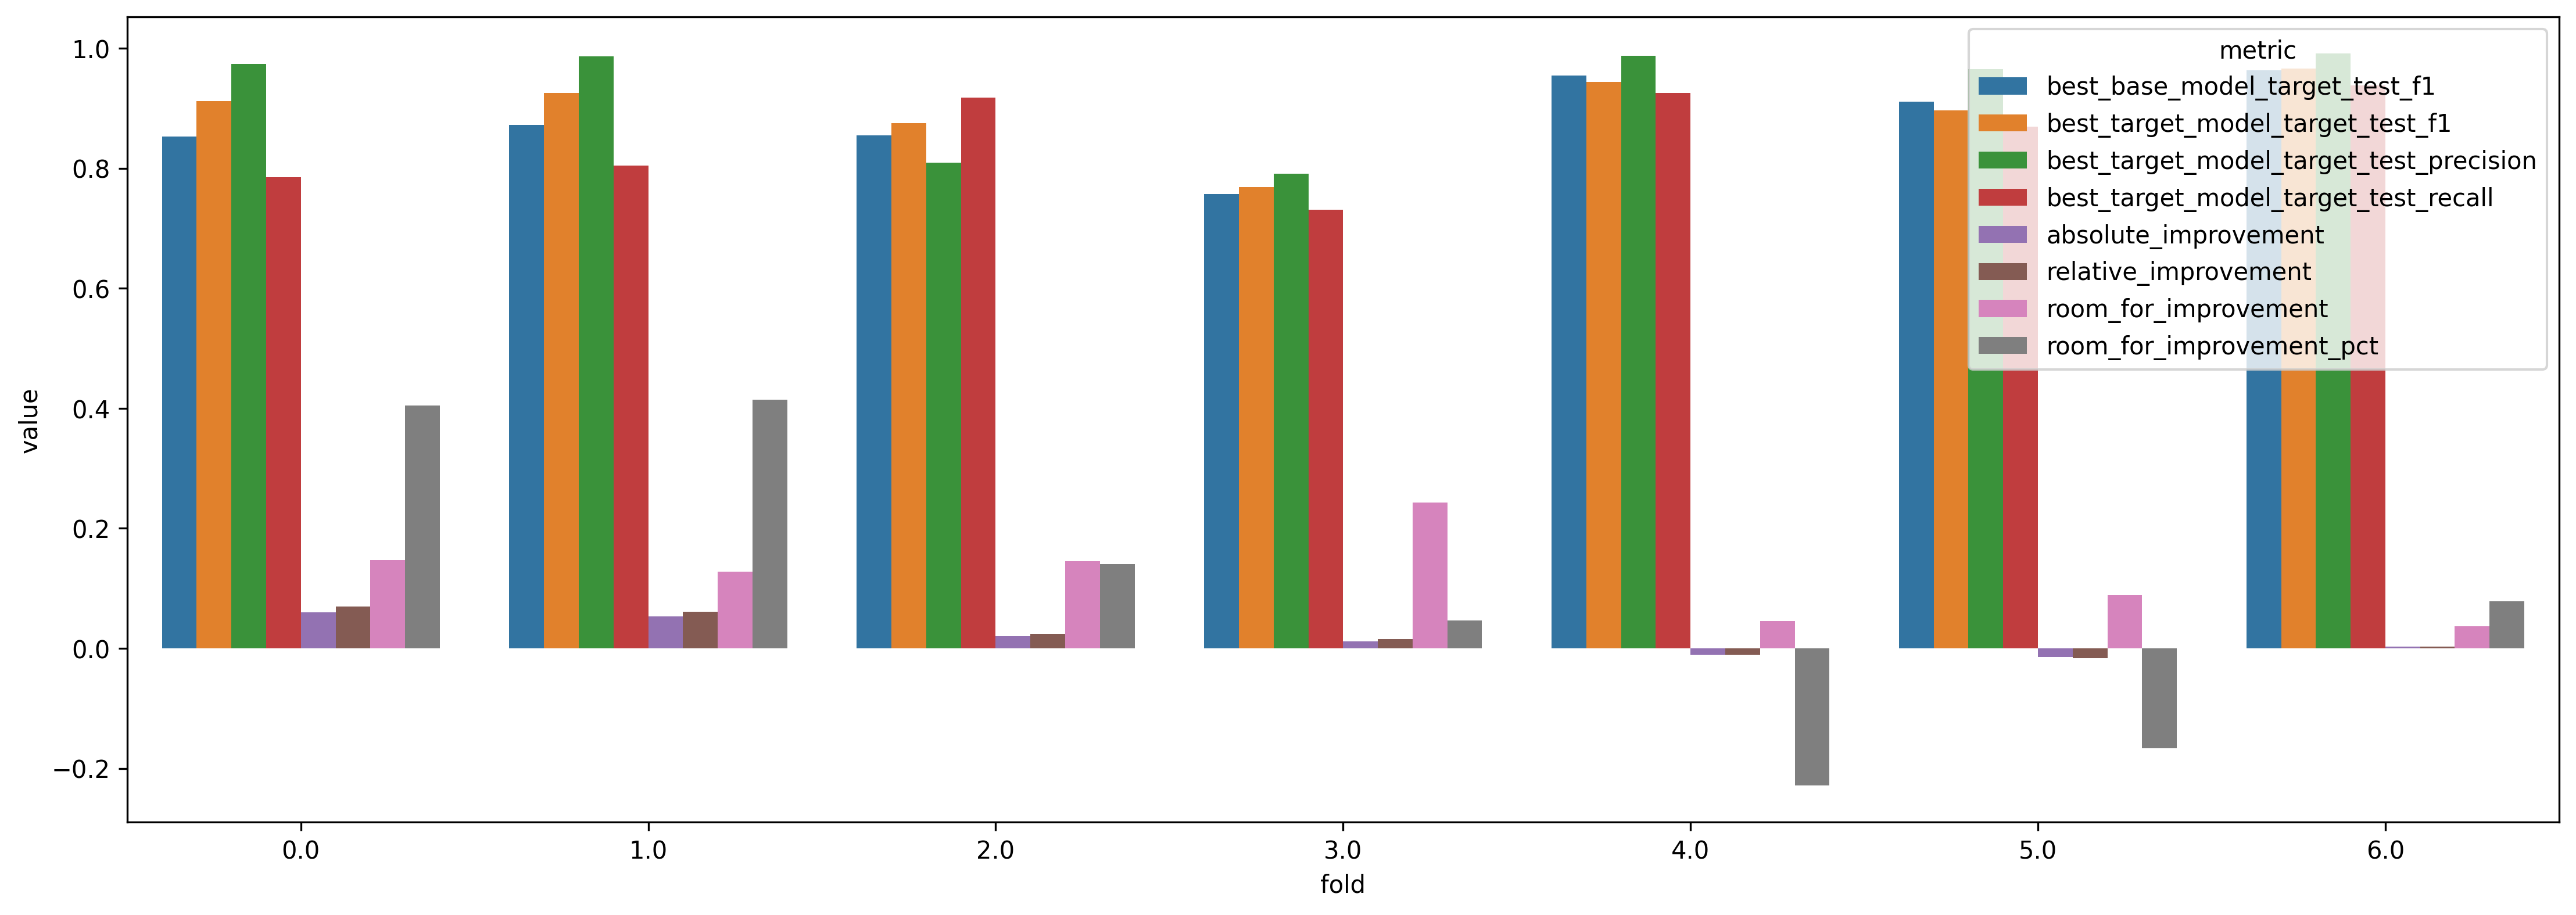

In [10]:
# Add Mean and Std and Median
df_metrics.loc['median'] = df_metrics.median(numeric_only=True)
df_metrics.loc['mean'] = df_metrics.mean(numeric_only=True)
df_metrics.loc['std'] = df_metrics.std(numeric_only=True)

display(df_metrics)

df_metrics.drop(['median','mean','std'], inplace=True)
df_metrics_melted = df_metrics.reset_index().melt(id_vars=['fold'], value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1','best_target_model_target_test_precision','best_target_model_target_test_recall','absolute_improvement','relative_improvement','room_for_improvement','room_for_improvement_pct'], var_name='metric', value_name='value')
plt.figure(figsize=(18,6),dpi=300)
display(df_metrics_melted)
sns.barplot(data=df_metrics_melted, x='fold', y='value', hue='metric')

In [11]:
# get best model hash where all folds had positive val f1 improvement
best_model_hash = df.groupby('hyperparameter_hash')['relative_improvement_target_val_f1'].filter(lambda x: (x > 0).all()).index
best_model_hash = df.loc[best_model_hash]['hyperparameter_hash'].unique()[0]
print(best_model_hash)
df_metrics = df[df['hyperparameter_hash'] == best_model_hash].copy()
# Compute Metrics For Paper
df_metrics = df_metrics[['fold','best_base_model_target_test_f1','best_target_model_target_test_f1']]
df_metrics.sort_values('fold', inplace=True)
# Add Absolute Improvement
df_metrics['absolute_improvement'] = df_metrics['best_target_model_target_test_f1'] - df_metrics['best_base_model_target_test_f1']
# Add Relative Improvement
df_metrics['relative_improvement'] = df_metrics['absolute_improvement'] / df_metrics['best_base_model_target_test_f1']
# Add Room For Improvement Metric
df_metrics['room_for_improvement'] = (1 - df_metrics['best_base_model_target_test_f1'])
df_metrics['room_for_improvement_pct'] = df_metrics['absolute_improvement'] / df_metrics['room_for_improvement']

from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report
from lib.train_utils import random_subsample
device = 'cpu'

# Load Model From Best Model Hash
# You can change this to load a different model if you want to inspect it
best_model_dir = [d for d in os.listdir(experiments_dir) if best_model_hash in d][0]
print(f'Loading model from {best_model_dir}')

run_dirs = os.listdir(f'{experiments_dir}/{best_model_dir}')
print(f'Runs: {run_dirs}')

df_metrics['best_target_model_target_test_precision'] = 0.0
df_metrics['best_target_model_target_test_recall'] = 0.0

run_dir = run_dirs[1]
print(f'Loading model from {run_dir}')
best_base_model_path = f'{experiments_dir}/{best_model_dir}/{run_dir}/best_target_model.pt'

criterion = nn.BCEWithLogitsLoss()
hyperparameters = json.load(open(f'{experiments_dir}/{best_model_dir}/{run_dir}/hyperparameters.json'))
target_participant = hyperparameters['target_participant']
data_path = hyperparameters['data_path']
batch_size = hyperparameters['batch_size']
fold = hyperparameters['fold']
print(f'Loading data from {data_path} for target participant {target_participant}')
from torch.utils.data import ConcatDataset

datasets = []
for i,p in enumerate(hyperparameters['participants'] + [target_participant]):
    print(f'Loading data from {data_path}/{p}_test.pt')
    X,y = torch.load(f'{data_path}/{p}_test.pt')
    datasets.append(TensorDataset(X,y,torch.tensor([i]*len(X))))

61c4dfba
Loading model from b64_t1.0_20251001_201839_61c4dfba
Runs: ['fold4_ejaz', 'fold1_asfik', 'fold3_anam', 'fold6_unk1', 'fold5_iftakhar', 'fold0_tonmoy', 'fold2_alsaad']
Loading model from fold1_asfik
Loading data from data/001_60s_window for target participant asfik
Loading data from data/001_60s_window/tonmoy_test.pt
Loading data from data/001_60s_window/alsaad_test.pt
Loading data from data/001_60s_window/anam_test.pt
Loading data from data/001_60s_window/ejaz_test.pt
Loading data from data/001_60s_window/iftakhar_test.pt
Loading data from data/001_60s_window/unk1_test.pt
Loading data from data/001_60s_window/asfik_test.pt


In [12]:

dataset = ConcatDataset(datasets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


In [14]:

from lib.models import Block
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        self.blocks = []
        self.blocks.append(Block(6,8))
        for _ in range(1):
            self.blocks.append(Block(8,8))
            self.blocks.append(Block(8,8,pool=False))

        self.blocks.append(Block(8,16,pool=False))
            
        self.blocks = nn.ModuleList(self.blocks)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, 1)
    
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        
        x = self.gap(x).squeeze(-1)
        # x = self.fc(x)
        return x
    
model = TestModel()
print(f'Loading base model from {best_base_model_path}')
model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
model.to(device)
embeddings = []
participants = []
model.eval()
model.to(device)
with torch.no_grad():
    for Xi,yi,pi in dataloader:
        Xi = Xi.to(device)
        embeddings.append(model(Xi).cpu())
        participants.append(pi.cpu())

    embeddings = torch.cat(embeddings).cpu()
    participants = torch.cat(participants).cpu()

rand_idx = torch.randperm(len(embeddings))[:1000]
embeddings = embeddings[rand_idx]
participants = participants[rand_idx]

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

Loading base model from ./experiments/b64_t1.0_20251001_201839_61c4dfba/fold1_asfik/best_target_model.pt


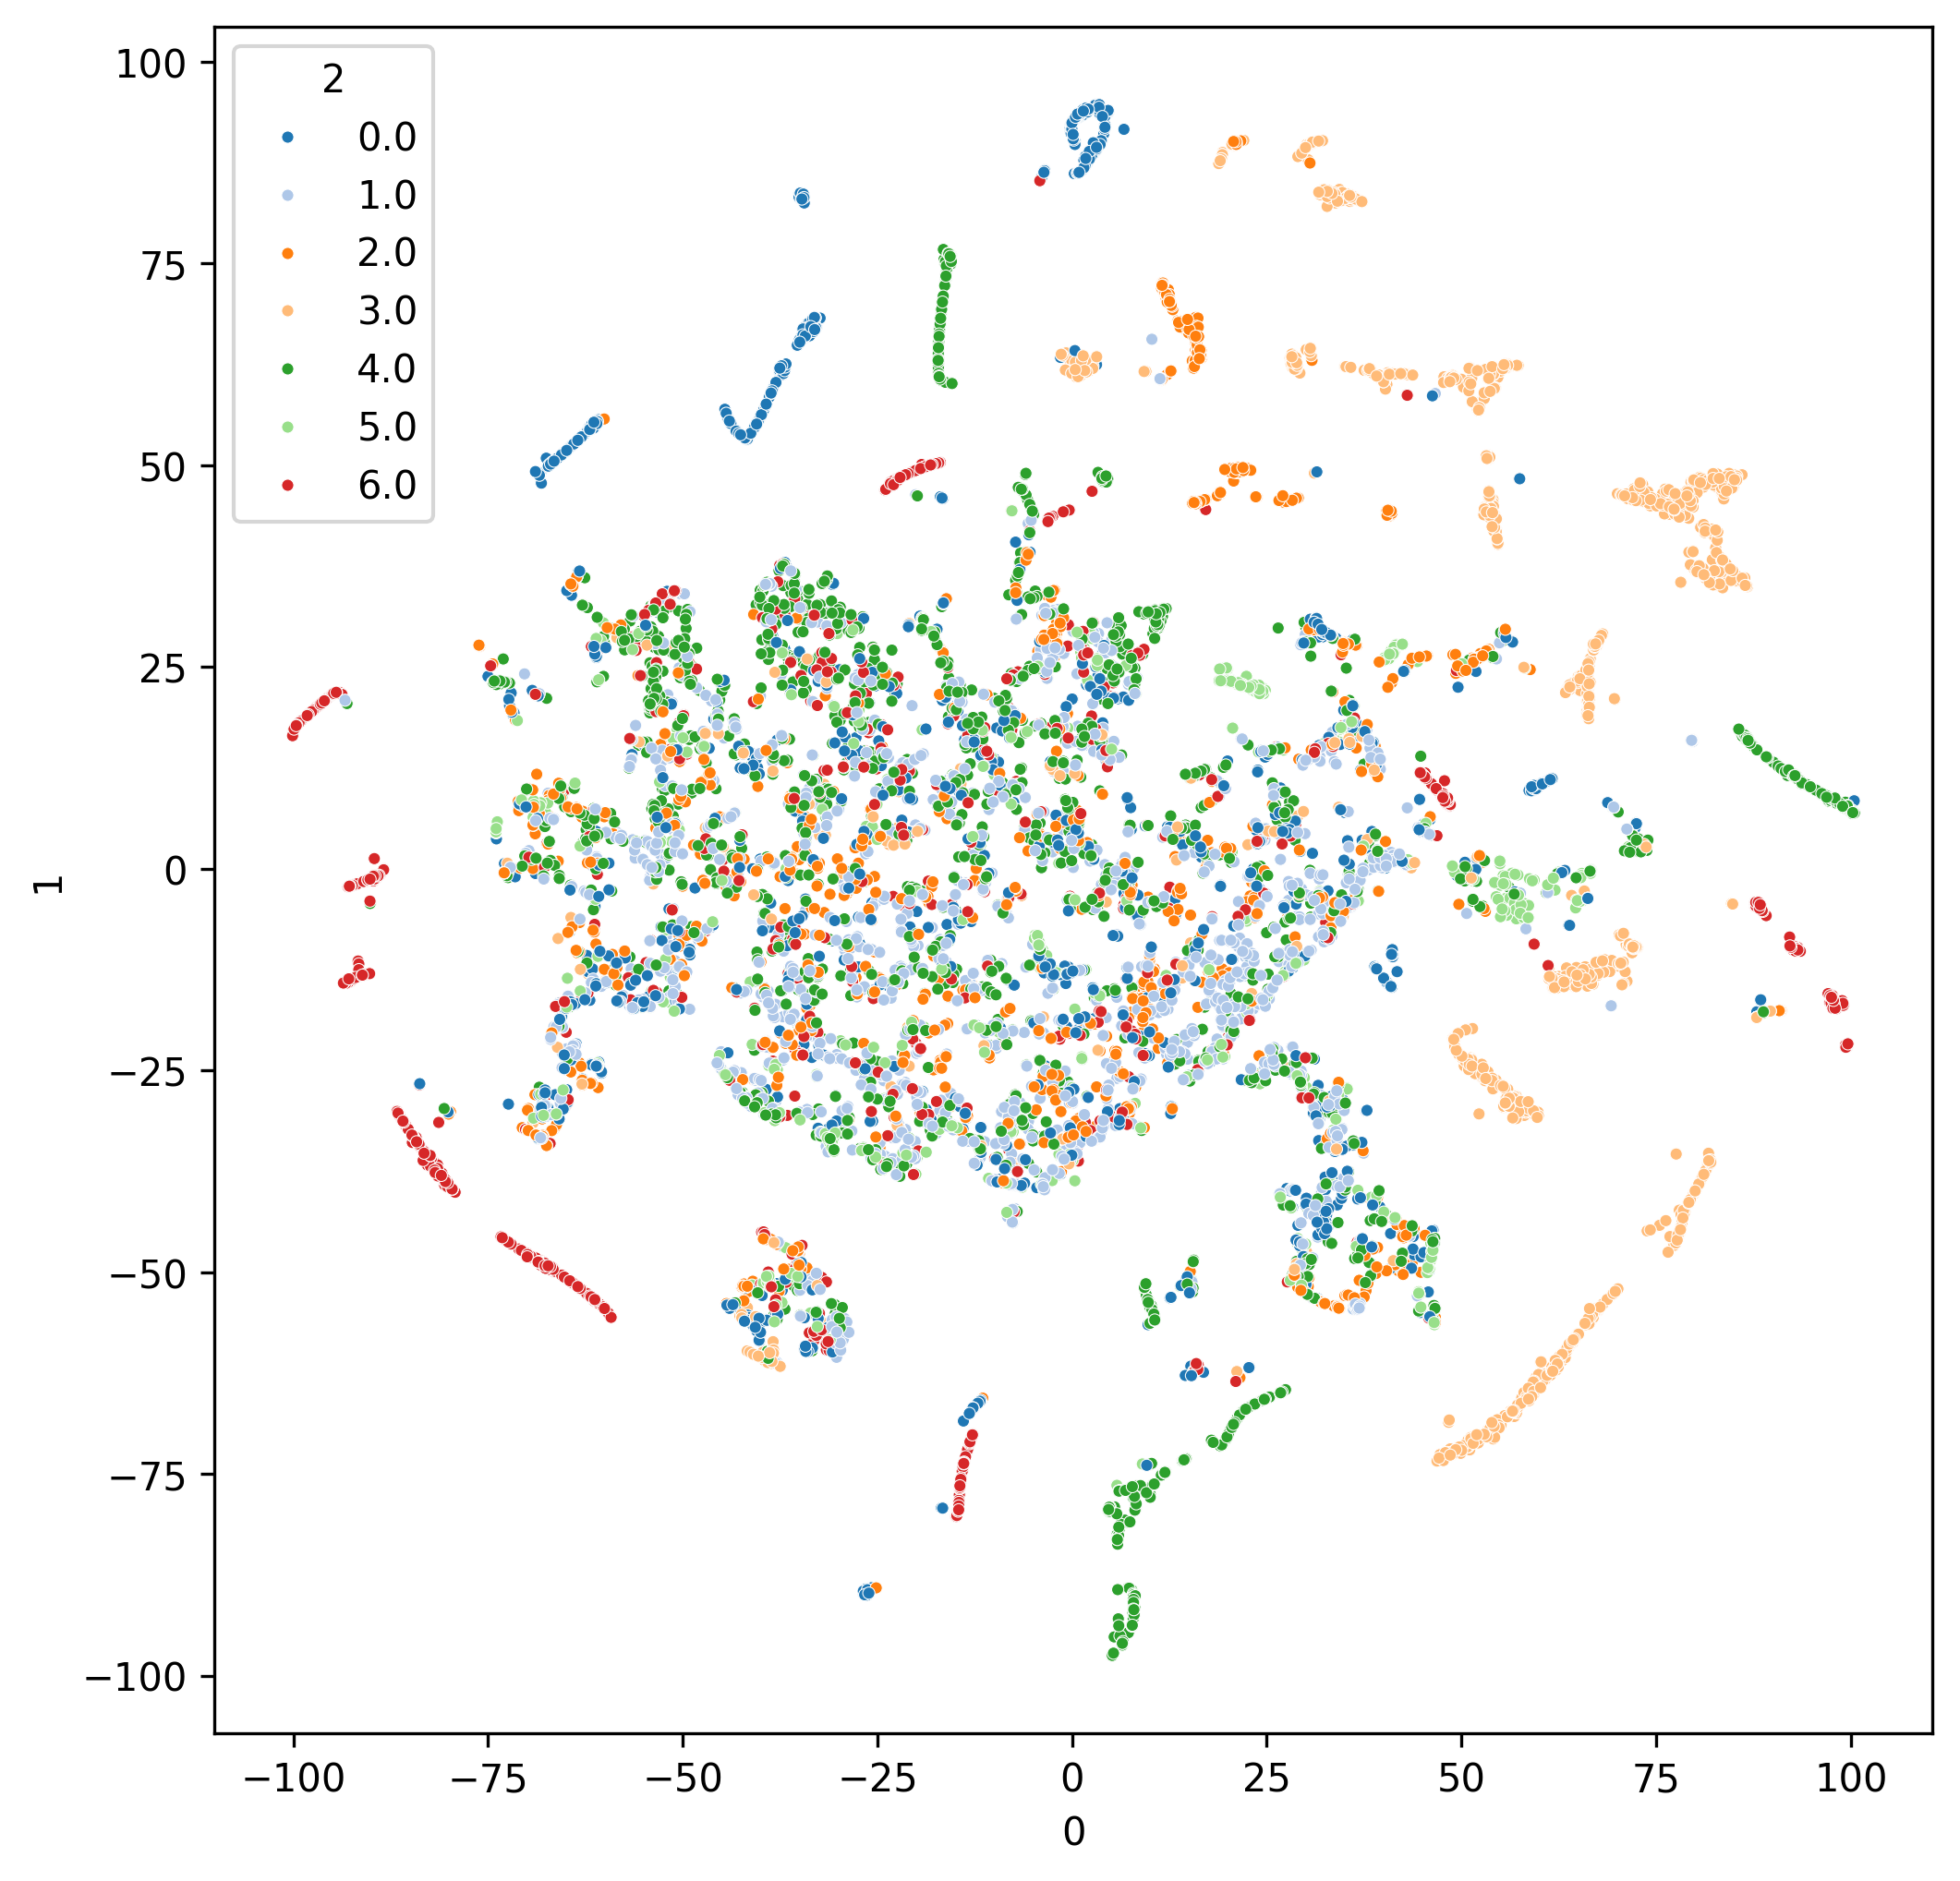

In [204]:

import pandas as pd
plt.figure(figsize=(8,8),dpi=300)
tsne_df = pd.DataFrame(torch.hstack([torch.from_numpy(embeddings_2d),participants.reshape(-1,1)]))
sns.scatterplot(data=tsne_df, x=0, y=1, hue=2, palette='tab20', legend='full', s=10)
plt.savefig('figure4.pdf', bbox_inches='tight')